# Import Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data_full = pd.read_csv("./data/generated/Analizsiz_v1.3.csv",dtype="category").convert_dtypes()
data_full = data_full.drop(["Unnamed: 0"],axis=1)
data_full.companyId = data_full.companyId.astype("category")
data = data_full.sample(1000)

In [3]:
def apply_worker_type(row):
    try:
        return row["newpositiongroupcode"][0]
    except:
        return None
data['worker_type'] = data.apply(apply_worker_type,axis=1)

def apply_level(row):
    try:
        level = row["newpositiongroupcode"][1]
        if level == "O":
            return 0
        return int(level)
    except:
        return -1
    
data['expertise'] = data.apply(apply_level,axis=1)

In [4]:
def group_company(com_id, id_mask):
    if id_mask < 99:
        return -2
    else:
        return com_id
dataset= data_full
counts_col = dataset.groupby("companyId")["companyId"].transform(len)
mask = counts_col
dataset["mask"] = counts_col
dataset.companyId.value_counts()
dataset["companyId"] = dataset.apply(lambda row: group_company(row["companyId"], row["mask"]), axis=1)
data_full

,classification,positionId,positiondescription,newpositiongroupcode,companyId,SalaryType,leavedate,salarycount,creationdate,Price,mainsectorname,mask
0,Satış - Pazarlama,2408,Satış Aplikasyon Sorumlusu,B2,-2,Net,NaN,12,2019-10-11 16:48:20.756,3200,Ticaret,2
1,Teknik Hizmetler,3302,Dizayn Ofis Şefi,B3,-2,Net,NaN,12,2019-10-11 16:48:25.168,3500,Yapı,3
2,Müşteri Hizmetleri,1351,Müşteri Temsilcisi,B1,279905,Net,NaN,12,2019-10-11 16:48:43.345,2020,Telekomünikasyon,124
3,Teknik Hizmetler,1819,Teknik Koordinatör,B4,273851,Net,NaN,12,2019-10-11 16:48:44.696,5250,Hizmet,154
4,Bilgi Teknolojileri,7539,Grafik Tasarım Sorumlusu,B2,-2,Net,NaN,12,2019-10-11 16:52:26.743,3500,Sigortacılık,2
...,...,...,...,...,...,...,...,...,...,...,...,...
500191,Elektrik / Elektronik,7067,Uzman Elektrik Mühendisi,B2,275266,Net,NaN,13,2020-09-11 18:21:06.062,18000,Yapı,619
500192,Teknik Hizmetler,5941,Argon Kaynakçısı,M2,-2,Net,NaN,12,2020-09-11 18:21:10.671,5000,Otomotiv,98
500193,İnsan Kaynakları,854,İnsan Kaynakları Sorumlusu,B2,-2,Net,NaN,12,2020-09-11 18:21:11.858,3500,Gıda,9
500194,İdari İşler,1587,Satın Alma Mühendisi,B2,272314,Brut,NaN,16,2020-09-11 18:21:14.796,7220,Otomotiv,869


In [5]:
data = data[["classification", "positiondescription", "mainsectorname","companyId","worker_type","expertise","Price"]]
data.rename(
    columns = {
        'classification':'position_sector', 
        'positiondescription':'position_name',
        "mainsectorname": "company_sector",
        "companyId": "company_id",
        "Price": "price"
    }, 
    inplace = True
)
data = data.dropna()
data = data.drop(["company_id"],axis=1)

data = data.astype(str)
data["expertise"] = data["expertise"].astype(int)
data["price"] = data["price"].astype(int)

data

,position_sector,position_name,company_sector,worker_type,expertise,price
274476,Denetim,İnspektör / Enspektör,Ticaret,B,2,6500
460922,İnşaat,Topoğraf,Otomotiv,B,2,4850
375515,Diğer,Test Personeli,Tekstil,B,1,3500
318485,Finans,Muhasebe Sorumlusu,Sağlık,B,2,5000
40279,Teknik Hizmetler,Montaj Elemanı,Elektrik & Elektronik,M,1,5000
...,...,...,...,...,...,...
162759,Makine,Makine Bakım Mühendisi,Üretim / Endüstriyel Ürünler,B,2,2720
13128,Tıp / Sağlık,Yoğun Bakım Hemşiresi,Sağlık,B,2,2480
73401,Teknik Hizmetler,Dizayn Ofis Mühendisi,Denizcilik,B,2,10000
90200,Denetim,Denetim Müdür Yardımcısı,Taşımacılık,B,4,8000


In [6]:
data.dtypes

position_sector    object
position_name      object
company_sector     object
worker_type        object
expertise           int64
price               int64
dtype: object

In [7]:
y = data["price"]
data = data.drop(["price"],axis=1)

In [8]:
n_components = 0
for x in data.columns:
    n_components += len(data[x].unique())
n_components

709

# Pick n for FAMD

In [7]:
import prince
for i in range(300,n_components,20):
    famd = prince.FAMD(
         n_components=i,
         n_iter=3,
         copy=True,
         check_input=True,
         engine='auto',
         random_state=42
    )
    famd.fit_transform(data)
    print(i, "->", sum(famd.explained_inertia_))
    
famd = prince.FAMD(
     n_components=n_components,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
)
famd.fit_transform(data)
print(n_components, "->", sum(famd.explained_inertia_))

300 -> 0.5436501078025497
320 -> 0.5722301554296534
340 -> 0.6007475613793634
360 -> 0.6292466613603948
380 -> 0.6576797571445927
400 -> 0.6861094728743973
420 -> 0.7145215006852632
440 -> 0.7429193239220001
460 -> 0.7713236595999677
480 -> 0.7996933812575358
500 -> 0.8280471080382045
520 -> 0.8564025601807399
540 -> 0.8847528454685337
560 -> 0.9130949513469466
580 -> 0.9414359565399033
600 -> 0.9697613171463993
620 -> 0.9938499422625802
640 -> 0.99874017646783
660 -> 1.0000000000000075
680 -> 1.0000000000000078
700 -> 1.000000000000007
712 -> 1.0000000000000078


In [28]:
data.dtypes

position_sector    category
position_name      category
company_sector     category
worker_type        category
expertise             int64
dtype: object

In [8]:
import prince
n = 600
famd = prince.FAMD(
     n_components=n,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
)
numeric_data = famd.fit_transform(data)
numeric_data

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
274476,0.340920,-0.515456,-0.456417,-0.050047,0.798275,-1.550194,0.331419,-0.116178,-0.089246,-0.647178,...,-0.074780,0.215605,0.086111,0.265368,0.039753,-0.011401,-0.172475,0.200009,0.142229,-0.310499
460922,0.026056,-0.172492,-0.568194,1.676991,-1.011308,0.267483,-0.045760,0.936985,0.946411,-0.237605,...,-0.268649,0.083185,0.379786,0.042494,0.000974,0.009523,0.021809,0.071134,-0.036183,0.029940
375515,-0.914088,-0.249753,-0.527962,-0.527141,0.248043,-0.175138,0.422067,2.069049,0.474157,0.246871,...,-0.397424,-2.055115,-0.179355,0.583645,0.037905,-0.048573,0.107166,-0.067830,-0.049610,-0.020162
318485,-0.085757,-0.823350,0.252229,-0.289066,0.098100,0.180088,0.882072,-0.021933,0.097117,0.133094,...,0.012377,0.023579,-0.065505,-0.042628,-0.083014,-0.004790,0.114549,0.090333,-0.066322,-0.014193
40279,-1.603286,1.468534,-0.044802,-0.271987,-0.547518,0.504954,-0.202685,-0.576773,-0.040043,-0.103310,...,-0.227268,0.073926,-0.293242,-0.515809,0.023800,0.004512,0.024836,0.022975,0.081682,0.040676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162759,-0.070831,0.121752,0.063663,-0.504992,-1.257330,0.962351,-0.813027,-0.655815,-0.422807,0.589060,...,0.066762,-0.553778,-0.098694,0.610657,0.009764,-0.011415,0.100840,-0.123766,-0.000981,-0.248305
13128,-0.178145,-0.740784,2.570491,-0.430576,-0.317245,0.945987,2.523440,0.010964,-0.649742,-0.549866,...,0.427692,1.800218,-0.984936,-0.321087,0.000925,0.007191,0.004310,-0.010020,0.008467,0.011255
73401,-0.225769,1.050386,-0.323445,2.806307,-1.571162,0.315456,1.363189,-0.104814,1.673939,-2.257680,...,0.583044,0.007814,-0.245100,1.364523,0.023982,0.048358,-0.084862,-0.009697,0.017039,0.002696
90200,2.188299,-0.482516,-0.620198,0.792332,1.283420,-0.733953,-0.331580,1.290834,-1.651579,-0.528373,...,-0.403098,-1.371611,-0.350041,-0.628942,0.009198,0.018879,-0.026961,0.103187,0.031752,-0.053952


# Train Models

In [9]:
# models -> KMEANS-DBSCAN-BIRCH-OPTICS-EM
from sklearn import cluster
model_result_dict = {}

In [ ]:
#KMeans
ks = list(range(2,20+1))
inertias = []

for k in ks:
    model = cluster.KMeans(n_clusters=k,random_state=42).fit(numeric_data)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, marker='o')
plt.xlabel('Küme sayısı (k)')
plt.ylabel('Distortion')
plt.show()

In [11]:
k=8
model_result_dict["kmeans"] = cluster.KMeans(n_clusters=k,random_state=42).fit(numeric_data).labels_

In [12]:
#DBSCAN
model = cluster.DBSCAN(
    #eps=1, min_samples=5
).fit(numeric_data)
model_result_dict["dbscan"] = model.labels_

In [13]:
#BIRCH
model = cluster.Birch(
    n_clusters=None,
    threshold=14.3,
    #branching_factor=100
).fit(numeric_data)
model_result_dict["birch"] = model.labels_

In [14]:
#OPTICS
model = cluster.OPTICS().fit(numeric_data)
model_result_dict["optics"] = model.labels_

/home/berkayulke/.local/lib/python3.10/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

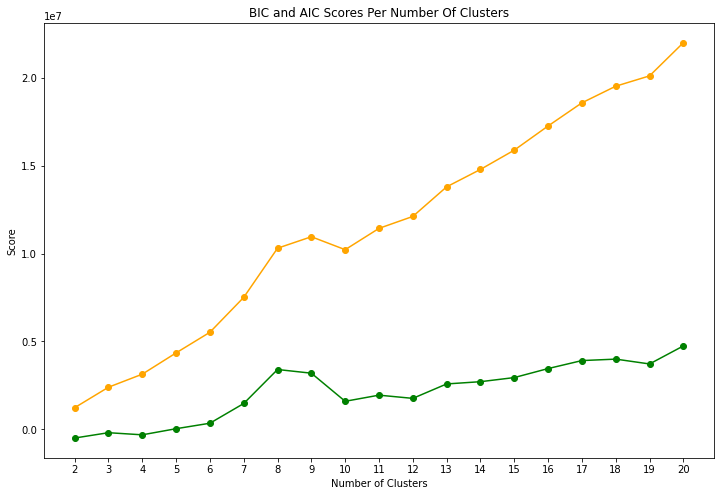

In [15]:
from sklearn.mixture import GaussianMixture

n_range = range(2,20+1)

bic_score = []
aic_score = []

for n in n_range:
    gm = GaussianMixture(
        n_components=n, 
        random_state=42, 
        n_init=10
    )
    gm.fit(numeric_data)
    
    bic_score.append(gm.bic(numeric_data))
    aic_score.append(gm.aic(numeric_data))
    
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In [16]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(
    n_components=8, 
    random_state=42, 
    n_init=10
)
model_result_dict["expectation maximisation"] = gm.fit_predict(numeric_data)

In [15]:
#Clusuters by position's sector
unique_values = list(data["position_sector"].unique())
model_result_dict["position sector"] = np.array([unique_values.index(x) for x in data.position_sector])

# Internal Evaluation

In [17]:
from sklearn import metrics

for key, value in model_result_dict.items():
    average_silhouette = metrics.silhouette_score(numeric_data,value)
    calinski_harabasz = metrics.calinski_harabasz_score(numeric_data,value)
    davies_bouldin = metrics.davies_bouldin_score(numeric_data,value)
    print(f"{key}\n\t{average_silhouette=}\n\t{calinski_harabasz=}\n\t{davies_bouldin=}")
    print()

kmeans
	average_silhouette=-0.07295182380334252
	calinski_harabasz=2.1496744764355147
	davies_bouldin=4.795831533567595

dbscan
	average_silhouette=-0.2729269969683349
	calinski_harabasz=0.5931192589283051
	davies_bouldin=3.0701848120771023

birch
	average_silhouette=0.06868335704643166
	calinski_harabasz=1.466951753175668
	davies_bouldin=0.8016328053280166

optics
	average_silhouette=-0.17073966025409343
	calinski_harabasz=1.632554389176887
	davies_bouldin=2.441019401058985

position sector
	average_silhouette=-0.013667646845268538
	calinski_harabasz=3.0217834031533677
	davies_bouldin=3.6402880447962627

expectation maximisation
	average_silhouette=-0.0729367539508194
	calinski_harabasz=2.1497946000070307
	davies_bouldin=4.7963055161058445



# External Evaluation

In [18]:
def create_heatmap_df():
    model_names = [*model_result_dict.keys()]
    return pd.DataFrame([],index=model_names,columns=model_names,dtype=float)

In [19]:
metric_funcs = [
    metrics.normalized_mutual_info_score,
    metrics.rand_score,
    metrics.adjusted_rand_score
]

metric_name_heatmap_dict = {}

for metric_func in metric_funcs:
    heatmap = create_heatmap_df()
    for key1, value1 in model_result_dict.items():
        for key2, value2 in model_result_dict.items():
            heatmap[key1][key2] = metric_func(value1,value2)
    metric_name_heatmap_dict[metric_func.__name__] = heatmap

<AxesSubplot:>

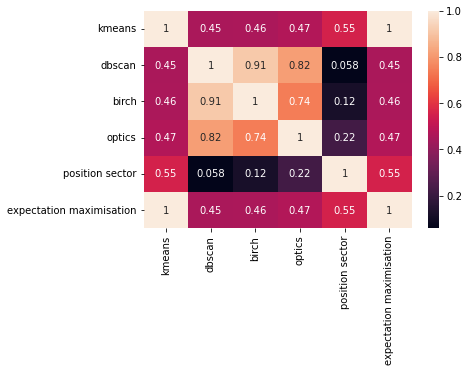

In [20]:
sns.heatmap(metric_name_heatmap_dict["rand_score"], annot=True)

# Model Training

In [16]:
#Example model training from one clustering algo
df = data.copy()
df["label"] = model_result_dict["position sector"]
df["price"] = y
df

,position_sector,position_name,company_sector,worker_type,expertise,label,price
274476,Denetim,İnspektör / Enspektör,Ticaret,B,2,0,6500
460922,İnşaat,Topoğraf,Otomotiv,B,2,1,4850
375515,Diğer,Test Personeli,Tekstil,B,1,2,3500
318485,Finans,Muhasebe Sorumlusu,Sağlık,B,2,3,5000
40279,Teknik Hizmetler,Montaj Elemanı,Elektrik & Elektronik,M,1,4,5000
...,...,...,...,...,...,...,...
162759,Makine,Makine Bakım Mühendisi,Üretim / Endüstriyel Ürünler,B,2,18,2720
13128,Tıp / Sağlık,Yoğun Bakım Hemşiresi,Sağlık,B,2,21,2480
73401,Teknik Hizmetler,Dizayn Ofis Mühendisi,Denizcilik,B,2,4,10000
90200,Denetim,Denetim Müdür Yardımcısı,Taşımacılık,B,4,0,8000


In [17]:
def split_by_feature(feature,dataset=data,threshold=10):
    unique_values = dataset[feature].unique()
    
    sub_datasets = []
    
    for val in unique_values:
        sub_datasets.append(
            dataset[dataset[feature] == val]
        )
        
    return [x for x in sub_datasets if len(x) > threshold]
clusters = split_by_feature("label", df, -1)

In [29]:
import xgboost as xgb

label_model_dict = {}

for cluster in clusters:
    label = cluster.label.values[0]
    
    cols=cluster.select_dtypes(exclude='int').columns.to_list()
    cluster.loc[:, cluster.dtypes == 'object'] = cluster.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    
    y = cluster["price"]
    x = cluster.drop(["label","price"],axis=1)    
    
    model = xgb.XGBRegressor(gpu_id=0,tree_method="gpu_hist",enable_categorical=True)
    model.fit(x, y)
    
    label_model_dict[label] = model

In [30]:
label_model_dict

{0: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, ...),
 1: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              